# Определение возраста покупателей

## Постановка задачи

Заказчик: сетевой супермаркет «Хлеб-Соль»

Требуется подготовить прототип модели машинного обучения, которая должна предсказать возраст покупателя в прикассовой зоне магазина. Модель поможет контролировать допросовестность кассиров при продаже алкоголя и предлагать товары, которые могут заинтересовать покупателя.

**Данные:** датасет фотографий и файл labels.csv, содержащий информацию о метках классов (колонки в файле: file_name и real_age). 

## План работы

- Загрузка необходимых библиотек
- Загрузка данных и их анализ
    - Проверка наличия пропусков
    - Проверка наличия дубликатов
- Исследовательский анализ данных
    - Распределение возрастов в данных
    - Анализ качества фотографий
- Обучение модели и оценка ее качества
- Написание функции для инициализации модели на основе ResNet50
    - Написание функции для обучения модели
    - Подбор параметров для получения метрики MAE < 8.0

## Загрузка данных

In [1]:
#импорт библиотек
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [2]:
RANDOM_STATE = 42

In [3]:
# загрузка файла с метками
try:
    labels = pd.read_csv('/datasets/faces/labels.csv')
    path = '/datasets/faces/final_files/'

except:
    labels = pd.read_csv('C:/Users/d.shubina/Documents/sprint_19/5_final_project/ageutk_full.csv')
    labels = labels.drop('gender', axis=1)
    labels.columns = ['file_name', 'real_age']
    path='C:/Users/d.shubina/Documents/sprint_19/5_final_project/UTKFace'
    
display(labels.head())
labels.info()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
# проверка наличия явных дубликатов дубликатов
labels.duplicated().sum()

0

In [5]:
# проверка наличия неявных дубликатов дубликатов
labels.drop('real_age', axis=1).duplicated().sum()

0

In [6]:
#  функция для загрузки фотографий
train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255., horizontal_flip=True, 
                                   vertical_flip=True, width_shift_range=0.2, height_shift_range=0.2)
val_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

train_datagen_flow = train_datagen.flow_from_dataframe(labels, 
                                                       path, 
                                                       target_size=(150, 150), 
                                                       x_col='file_name', 
                                                       y_col='real_age',
                                                       batch_size=16,
                                                       class_mode='raw',
                                                       subset='training',
                                                       seed=RANDOM_STATE)

val_datagen_flow = val_datagen.flow_from_dataframe(labels, 
                                                   path, 
                                                   target_size=(150, 150), 
                                                   x_col='file_name', 
                                                   y_col='real_age',
                                                   batch_size=16,
                                                   class_mode='raw',
                                                   subset='validation',
                                                   seed=RANDOM_STATE)



Found 5694 validated image filenames.
Found 1897 validated image filenames.


**Результаты раздела**

Датасет содержит: 7591 фотографию.

Файл с метками классов: содержит 7591 запись (соответствует количеству фотографий), пустых значений нет, переименования столбцов не требуются, дубликаты не выявлены.

## Исследовательский анализ данных

In [7]:
def hist_box_diagramm(df, list):
    """
    функция для строительства гистограммы и ящика с усами.
    на вход получает датафрейм и список полей для которых нужно построить графики
    """
    for element in list:   
        
        # создание объекта из двух: гстограммы и ящика с усами
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)})
        
        # назначение графика каждой переменной
        sns.boxplot(df[element], orient='h', ax=ax_box)
        sns.histplot(df, x=element, bins=97);
        
        print(f"Графики для поля: {element}: рспределение фотографий по возрастам.")

        # удаление подписи для оси х
        ax_box.set(xlabel='')
        plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: real_age: рспределение фотографий по возрастам.


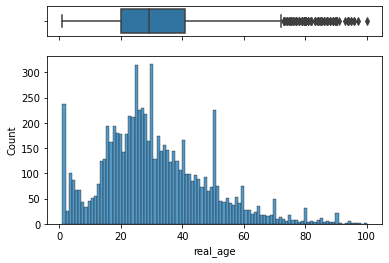

In [8]:
# построение гистрограмм
hist_box_diagramm(labels, ['real_age'])

In [9]:
# подсчет уникальных значений возрастов
len(labels['real_age'].unique())

97

In [10]:
# отбор 16 случайных файлов для последующего отображения
labels_short = labels.sample(16, random_state=RANDOM_STATE).reset_index(drop=True)
labels_short.head()

,file_name,real_age
0,000800.jpg,1
1,002644.jpg,46
2,006525.jpg,35
3,005572.jpg,23
4,000586.jpg,47


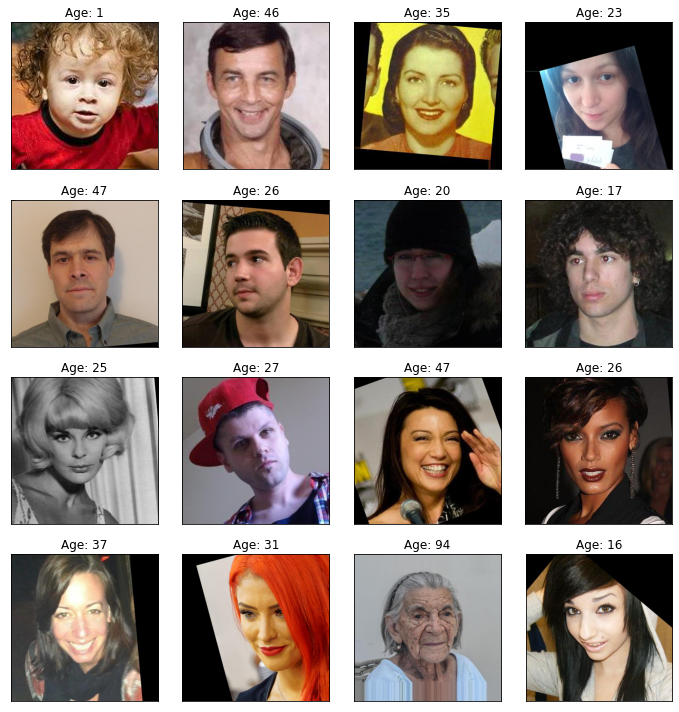

In [11]:
# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    image = Image.open('/datasets/faces/final_files/' + labels_short.loc[i, 'file_name'])
    plt.imshow(np.array(image)) 
    plt.title('Age: ' + str(labels_short.loc[i, 'real_age']))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Результаты раздела**
Распределение возрастов в данных имеет два пика: около 27 лет и около 0 лет.

Размер изображений при загрузке приведен к единому. Общая ориентация фотографий примерно одинакова. Некоторые уже повернуты, чтобы выровнять положение лица. Фотографии в датасете очень разного качества: есть цветные и черно-белые, сделанные при разном освещении и с разным разрешением. Теоретически, это должно снизить качество обучения модели, т.к. при определении возраста клиента для принятия решения, лицо будут фотографировать при схожих условиях.

## Обучение модели

Код, указанный ниже, выполнялся на платформе Яндекс-Практикума, т.к. они для своих студентов предоставляют платформу с GPU для работы с изображениями.

import numpy as np
import pandas as pd

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam

def load_train(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255., horizontal_flip=True, 
                                   vertical_flip=True, width_shift_range=0.2, height_shift_range=0.2)
    
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen_flow = datagen.flow_from_dataframe(labels, 
                                                     directory=path+'/final_files',
                                                     x_col='file_name', 
                                                     y_col='real_age', 
                                                     target_size=(224, 224), 
                                                     batch_size=16, 
                                                     class_mode='raw', 
                                                     subset='training', 
                                                     seed=12345)
    return train_datagen_flow
 
def load_test(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen_flow = datagen.flow_from_dataframe(labels, 
                                                   directory=path+'/final_files',
                                                   x_col='file_name', 
                                                   y_col='real_age', 
                                                   target_size=(224, 224), 
                                                   batch_size=16, 
                                                   class_mode='raw', 
                                                   subset='validation', 
                                                   seed=12345)
    return test_datagen_flow
 
def create_model(input_shape):
    
    optimizer = Adam(lr=0.00001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    
    model = Sequential()  
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=97, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps

Epoch 1/10
356/356 - 102s - loss: 1071.1824 - mae: 28.6633 - val_loss: 1137.4545 - val_mae: 29.2644

Epoch 2/10
356/356 - 95s - loss: 540.0964 - mae: 19.6896 - val_loss: 641.0284 - val_mae: 21.4883

Epoch 3/10
356/356 - 94s - loss: 246.3363 - mae: 12.1593 - val_loss: 141.2018 - val_mae: 8.8585

Epoch 4/10
356/356 - 96s - loss: 149.0070 - mae: 8.9784 - val_loss: 183.5277 - val_mae: 10.1908

Epoch 5/10
356/356 - 95s - loss: 117.0319 - mae: 8.0184 - val_loss: 101.2412 - val_mae: 7.7469

Epoch 6/10
356/356 - 96s - loss: 100.8873 - mae: 7.5559 - val_loss: 96.5286 - val_mae: 7.4275

Epoch 7/10
356/356 - 96s - loss: 89.5369 - mae: 7.1566 - val_loss: 88.8702 - val_mae: 7.1087

Epoch 8/10
356/356 - 98s - loss: 84.0921 - mae: 6.9967 - val_loss: 89.8577 - val_mae: 7.0989

Epoch 9/10
356/356 - 101s - loss: 80.1763 - mae: 6.8099 - val_loss: 99.4482 - val_mae: 7.6268

Epoch 10/10
356/356 - 103s - loss: 73.9848 - mae: 6.5650 - val_loss: 95.0342 - val_mae: 7.1515

119/119 - 11s - loss: 95.0342 - mae: 7.1515

Test MAE: 7.1515
```

## Анализ обученной модели

Фотографии в датасете очень разного качества: есть цветные и черно-белые, сделанные при разном освещении и с разным разрешением. Теоретически, это должно снизить качество обучения модели, т.к. при определении возраста клиента для принятия решения, лицо будут фотографировать при схожих условиях.

Для предсказания возраста была обучена модель, созданная на основе ResNet50.
Метрика MAE на тестовом наборе данных = 7.1515

